**Detector de máskara con Aprendizaje profundo**

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import os
import random
import tqdm
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet

In [3]:
import config_tr

from IPython.display import Image

In [4]:
%matplotlib inline

** Los datos han sido descargados de: https://www.kaggle.com/andrewmvd/face-mask-detection **

**Dividiendo los datos en entrenamiento y validación**

In [5]:
if 'train' not in os.listdir(config_tr.PATH_IMAGES):
    os.mkdir(config_tr.PATH_IMAGES + 'train')
if 'val' not in os.listdir(config_tr.PATH_IMAGES):
    os.mkdir(config_tr.PATH_IMAGES + 'val')

for target in ('with_mask', 'without_mask'):
    if target not in os.listdir(config_tr.PATH_IMAGES + 'train/'):
        os.mkdir(config_tr.PATH_IMAGES + 'train/' + target)
    if target not in os.listdir(config_tr.PATH_IMAGES + 'val/'):
        os.mkdir(config_tr.PATH_IMAGES + 'val/' + target)

In [6]:
for target in ('with_mask', 'without_mask'):
    if target in os.listdir(config_tr.PATH_IMAGES):
        for image_filename in tqdm.tqdm(os.listdir(config_tr.PATH_IMAGES + target + '/')):
            if random.random() > 0.2:
                os.rename(config_tr.PATH_IMAGES + target + '/' + image_filename, 
                          config_tr.PATH_IMAGES + '/train/' + target + '/' + image_filename)
            else:
                os.rename(config_tr.PATH_IMAGES + target + '/' + image_filename, 
                          config_tr.PATH_IMAGES + '/val/' + target + '/' + image_filename)
        os.rmdir(config_tr.PATH_IMAGES + target)

**Analizando algunas imágenes**

In [7]:
datagen_prueba = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(config_tr.PATH_IMAGES + 'train',
                                              target_size=(512, 512),
                                              class_mode='binary',
                                              batch_size=10,
                                              shuffle=True)

Found 6026 images belonging to 2 classes.


In [8]:
imagenes, target = next(datagen_prueba)

In [9]:
muestra_mascara = [imagenes[enum] for enum, target_ in enumerate(target) if target[enum] == 1]
muestra_no_mascara = [imagenes[enum] for enum, target_ in enumerate(target) if target[enum] == 0]

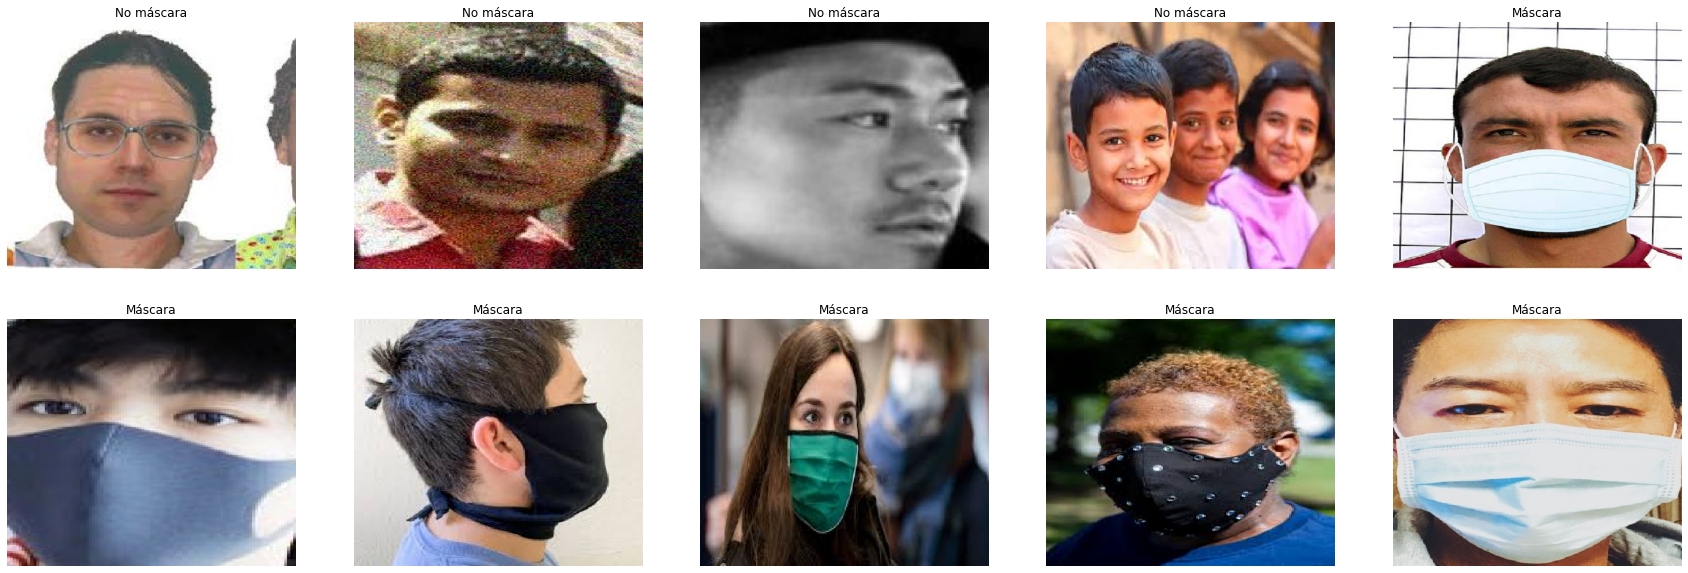

In [10]:
# Concat the data in a single list and del the above two list
muestra = muestra_mascara + muestra_no_mascara
num_saltar = len(muestra_mascara)

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(10):
    ax[i // 5, i % 5].imshow(array_to_img(muestra[i]))
    if i < num_saltar:
        ax[i // 5, i % 5].set_title("No máscara")
    else:
        ax[i // 5, i % 5].set_title("Máscara")
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')
plt.show()

**Procesamiento de imágenes**

In [11]:
BATCH_SIZE = 64

In [12]:
tr_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
tr_generator = tr_datagen.flow_from_directory(config_tr.PATH_IMAGES + 'train',
                                              target_size=config_tr.SHAPE,
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

val_generator = val_datagen.flow_from_directory(config_tr.PATH_IMAGES + 'val',
                                                target_size=config_tr.SHAPE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 6026 images belonging to 2 classes.
Found 1527 images belonging to 2 classes.


**Datos Balanceados**

<AxesSubplot:>

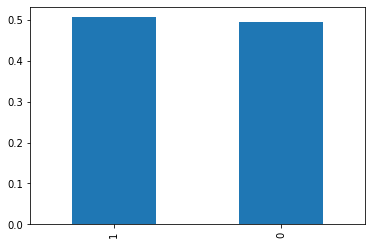

In [14]:
pd.Series(tr_generator.labels).value_counts(normalize=True).plot.bar()

<AxesSubplot:>

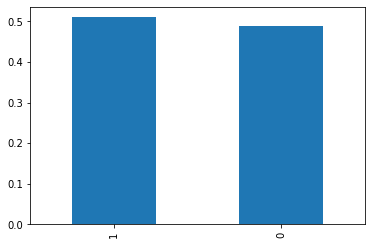

In [15]:
pd.Series(val_generator.labels).value_counts(normalize=True).plot.bar()

**Deep Learning - Transferencia de aprendizaje**

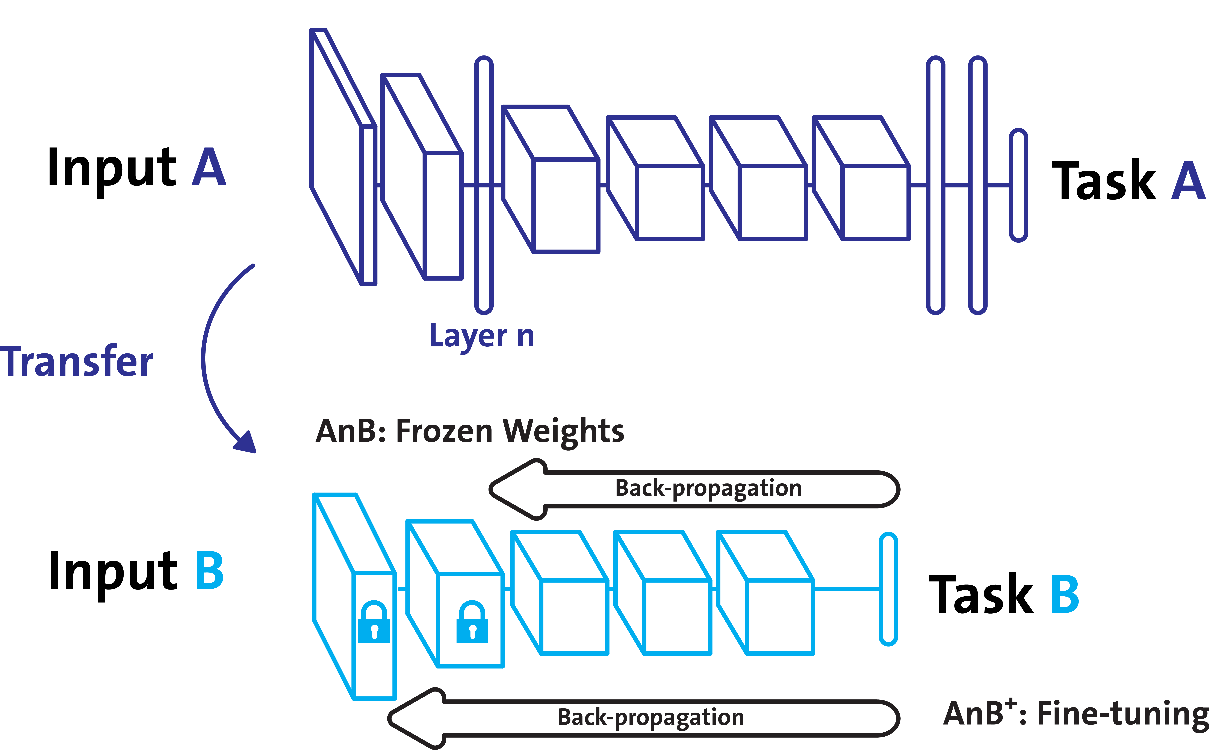

In [16]:
Image('https://www.oreilly.com/library/view/java-deep-learning/9781788997454/assets/74b69371-b7bf-47e7-8f0a-9ec9bde897ac.png') 

In [17]:
base_model = MobileNet(include_top=False, weights='imagenet', pooling='max', input_shape=(*config_tr.SHAPE, 3))

for layer in base_model.layers:
    layer.W_regularizer = tf.keras.regularizers.l2(1e-3)
    layer.trainable = True

output = base_model.output
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = tf.keras.models.Model(base_model.input, output)

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

conv_pw_9_bn (BatchNormaliza (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_9_relu (ReLU)        (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_10 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
__________

In [19]:
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6))

**Entrenando el modelo**

In [20]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-10, verbose=1)

In [21]:
model.fit(tr_generator,
          validation_data=val_generator,
          verbose=2,
          epochs=100,
          steps_per_epoch=len(tr_generator.filenames) // BATCH_SIZE,
          validation_steps=len(val_generator.filenames) // BATCH_SIZE,
          callbacks=[es, rlr])

Epoch 1/100


C:\Users\jahaz\.conda\envs\lookiero\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


94/94 - 63s - loss: 0.2152 - accuracy: 0.9104 - val_loss: 0.3287 - val_accuracy: 0.8832
Epoch 2/100
94/94 - 61s - loss: 0.0498 - accuracy: 0.9834 - val_loss: 0.0273 - val_accuracy: 0.9912
Epoch 3/100
94/94 - 62s - loss: 0.0299 - accuracy: 0.9891 - val_loss: 0.0199 - val_accuracy: 0.9939
Epoch 4/100
94/94 - 63s - loss: 0.0210 - accuracy: 0.9928 - val_loss: 0.0142 - val_accuracy: 0.9959
Epoch 5/100
94/94 - 62s - loss: 0.0138 - accuracy: 0.9950 - val_loss: 0.0176 - val_accuracy: 0.9946
Epoch 6/100
94/94 - 62s - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.0165 - val_accuracy: 0.9946
Epoch 7/100
94/94 - 61s - loss: 0.0119 - accuracy: 0.9955 - val_loss: 0.0139 - val_accuracy: 0.9959
Epoch 8/100
94/94 - 62s - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0180 - val_accuracy: 0.9952
Epoch 9/100
94/94 - 61s - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0179 - val_accuracy: 0.9973
Epoch 10/100

Epoch 00010: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
94/94 - 60s - loss

**Evaluando el modelo**

<AxesSubplot:>

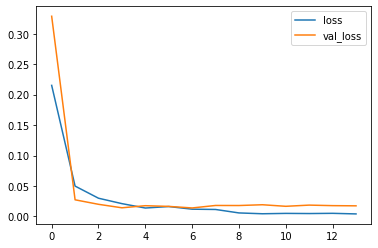

In [22]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

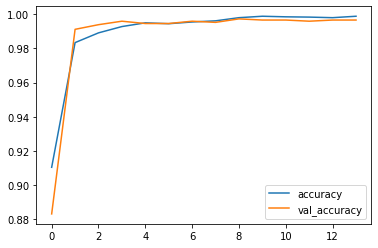

In [23]:
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot()

In [24]:
pred_val = model.predict(val_generator, steps=len(val_generator.filenames) // BATCH_SIZE + 1, verbose=1)

 7/24 [=======>......................] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 1s

C:\Users\jahaz\.conda\envs\lookiero\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 149ms/step


In [25]:
pred_val = pred_val.ravel()[:len(val_generator.filenames)]

In [26]:
pred_val_df = pd.DataFrame({'pred': pred_val, 'target': val_generator.classes})

In [27]:
pred_val_df.head()

,pred,target
0,0.000239,0
1,0.000009,0
2,0.000008,0
3,0.000100,0
4,0.000163,0


target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

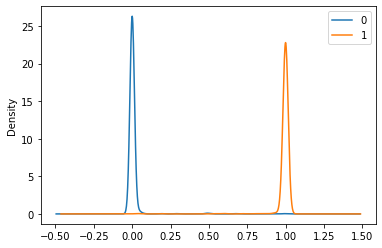

In [28]:
pred_val_df.groupby('target')['pred'].plot(kind='density', legend=True)

In [29]:
roc_auc = metrics.roc_auc_score(pred_val_df['target'], pred_val_df['pred'])
print(roc_auc)

0.9998781517508393


In [30]:
fpr, tpr, threshold = metrics.roc_curve(pred_val_df['target'], pred_val_df['pred'])

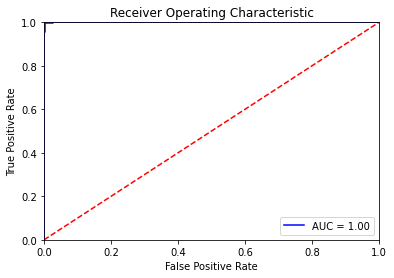

In [31]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Guardando los modelos**

In [32]:
model_json = model.to_json()

In [33]:
with open(config_tr.MODEL_PATH_JSON, 'w') as json_file:
    json_file.write(model_json)

In [34]:
model.save_weights(config_tr.MODEL_PATH_H5)